In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd

metadata = pd.read_csv('/content/test_metadata_rootclass.csv')
embeddings = pd.read_csv('/content/test_embeddings_meanpool.csv')

merged_df = pd.merge(metadata, embeddings, on='video_id')

# print(metadata.head())
# print(embeddings.head())
merged_df

,video_id,start_time_seconds,end_time_seconds,labels,root_classes,feature_0,feature_1,feature_2,feature_3,feature_4,...,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127
0,iZcPr3wgJCw,30.0,40.0,['Engine knocking'],['Engine'],64.9,221.3,85.4,7.4,215.8,...,124.0,191.2,144.8,65.8,87.1,153.0,112.2,216.3,187.1,173.0
1,iZmn0dUXP9E,40.0,50.0,"['Toothbrush', 'Electric toothbrush']","['Domestic sounds, home sounds']",93.7,112.2,100.1,20.7,166.8,...,54.9,181.4,106.5,192.7,50.5,67.4,95.2,123.9,190.5,132.4
2,iZ2K_GPtc6g,30.0,40.0,"['Sine wave', 'Chirp tone']",['Other sourceless'],170.6,72.8,107.5,83.9,118.0,...,96.5,204.1,215.9,80.7,77.4,20.7,80.1,190.3,42.6,146.3
3,iZtF1lUPbEQ,20.0,30.0,"['Fart', 'Buzz', 'Music']","['Wild animals', 'Digestive', 'Music', 'Onomat...",170.6,118.4,102.6,128.2,134.6,...,120.7,27.1,137.5,150.0,90.3,94.5,100.1,136.5,156.4,119.3
4,iZFRfh1Wjt8,420.0,430.0,"['Vehicle', 'Vehicle horn, car horn, honking',...","['Alarm', 'Vehicle']",73.9,166.3,82.6,17.5,230.2,...,91.4,149.5,149.7,134.8,124.3,62.7,146.1,166.0,52.4,85.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21777,2Cmn2lplGfc,30.0,40.0,"['Propeller, airscrew']",['Vehicle'],59.7,189.7,13.3,18.3,179.3,...,255.0,214.7,253.7,112.6,123.7,90.4,110.9,138.4,58.5,113.1
21778,2ClQcAd-wJg,30.0,40.0,"['Speech', 'Buzzer']","['Alarm', 'Human voice']",55.0,147.8,237.5,223.2,126.1,...,65.6,122.0,178.2,192.2,198.1,175.9,237.6,61.6,182.2,153.4
21779,-Sclnq22t7o,30.0,40.0,"['Burping, eructation']",['Digestive'],82.0,77.8,171.4,86.6,112.6,...,147.6,129.8,32.3,148.6,101.8,54.0,85.2,107.8,183.9,112.1
21780,-SD9DkKyOrY,30.0,40.0,"['Percussion', 'Drum kit', 'Drum', 'Snare drum...",['Music'],180.4,107.9,81.7,80.9,99.4,...,42.1,33.7,0.7,233.8,150.8,93.2,255.0,128.7,137.1,230.7


In [5]:
features = merged_df.drop(columns=['video_id', 'start_time_seconds', 'end_time_seconds', 'labels', 'root_classes']).values
features.shape

(21782, 128)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree

# # Standardize the features
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)

# # Apply PCA to reduce dimensions from 1280 to 128
# pca = PCA(n_components=128)
# features_reduced = pca.fit_transform(features_scaled)

kd_tree = KDTree(features, leaf_size=40, metric='euclidean')

# Query the KDTree for the nearest point to each point (k=2)
distances, indices = kd_tree.query(features, k=2)

# The distances array will contain distances to the nearest point (excluding itself)
# So we take all rows and the second column ([i][1])
nearest_distances = distances[:, 1]

print("Nearest distances for each point:", nearest_distances)

nearest_indices = indices[:, 1]

print("Indices of nearest neighbors for each point:", nearest_indices)

Nearest distances for each point: [650.08257168 366.36713826 337.01130545 ... 341.75268836 358.67284536
 472.76552328]
Indices of nearest neighbors for each point: [ 1741  2807  6094 ...  4329 13866 11804]


In [7]:
import numpy as np

# Calculate the 90th percentile of the nearest distances
percentile_90 = np.percentile(nearest_distances, 90)
percentile_80 = np.percentile(nearest_distances, 80)
percentile_70 = np.percentile(nearest_distances, 70)

print(percentile_90)
print(percentile_80)
print(percentile_70)

532.0083532612917
486.88623721506286
457.0950612112504


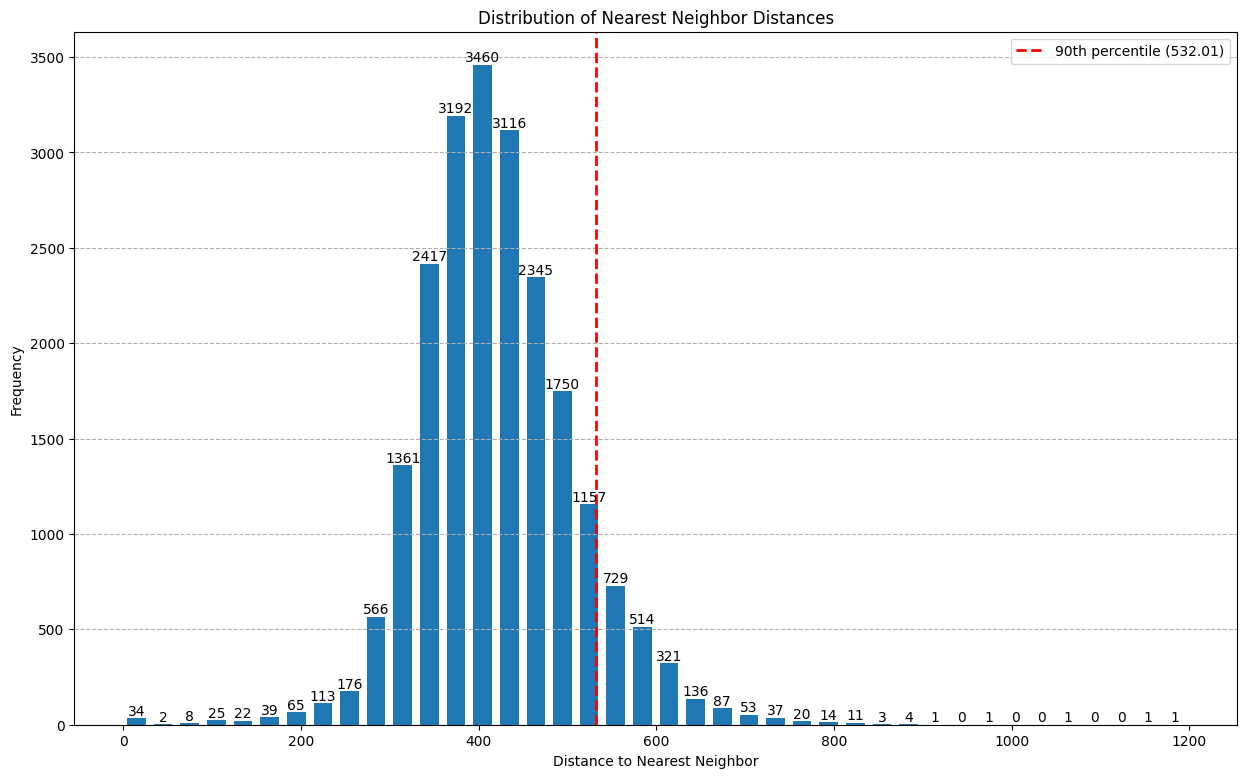

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a histogram of the nearest distances
num_bins = 40
hist, bins = np.histogram(nearest_distances, bins=num_bins)

# Calculate the width of each bin for the bar graph
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

# Create a figure for the plot
plt.figure(figsize=(15, 9))

# Plot the bar graph
bars = plt.bar(center, hist, align='center', width=width)
plt.xlabel('Distance to Nearest Neighbor')
plt.ylabel('Frequency')
plt.title('Distribution of Nearest Neighbor Distances')
plt.grid(axis='y', linestyle='--')

# Annotate each bar with the frequency value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.axvline(x=percentile_90, color='red', linestyle='--', linewidth=2, label=f'90th percentile ({percentile_90:.2f})')
plt.legend()

plt.show()

In [9]:
unique_indices = set(nearest_indices)
has_duplicates = len(nearest_indices) - len(unique_indices)
print(has_duplicates)

10439


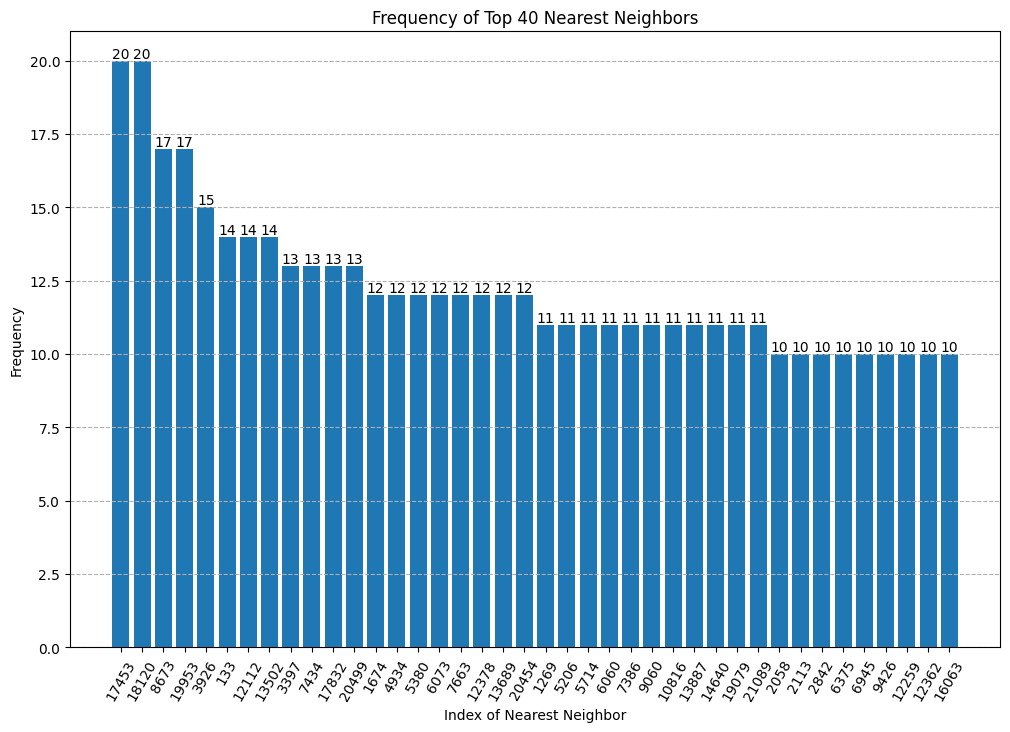

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Count the frequency of each index in nearest_indices
unique, counts = np.unique(nearest_indices, return_counts=True)
index_freq = dict(zip(unique, counts))

# Sort the frequencies in descending order and select the top 40
top_40_freq = sorted(index_freq.items(), key=lambda x: x[1], reverse=True)[:40]
top_40_indices = [item[0] for item in top_40_freq]
top_40_counts = [item[1] for item in top_40_freq]

# Create a bar graph for the top 40 nearest neighbor indices
plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(top_40_indices)), top_40_counts, tick_label=top_40_indices)
plt.xlabel('Index of Nearest Neighbor')
plt.ylabel('Frequency')
plt.title('Frequency of Top 40 Nearest Neighbors')
# Rotate labels to avoid overlap
plt.xticks(rotation=60)
plt.grid(axis='y', linestyle='--')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

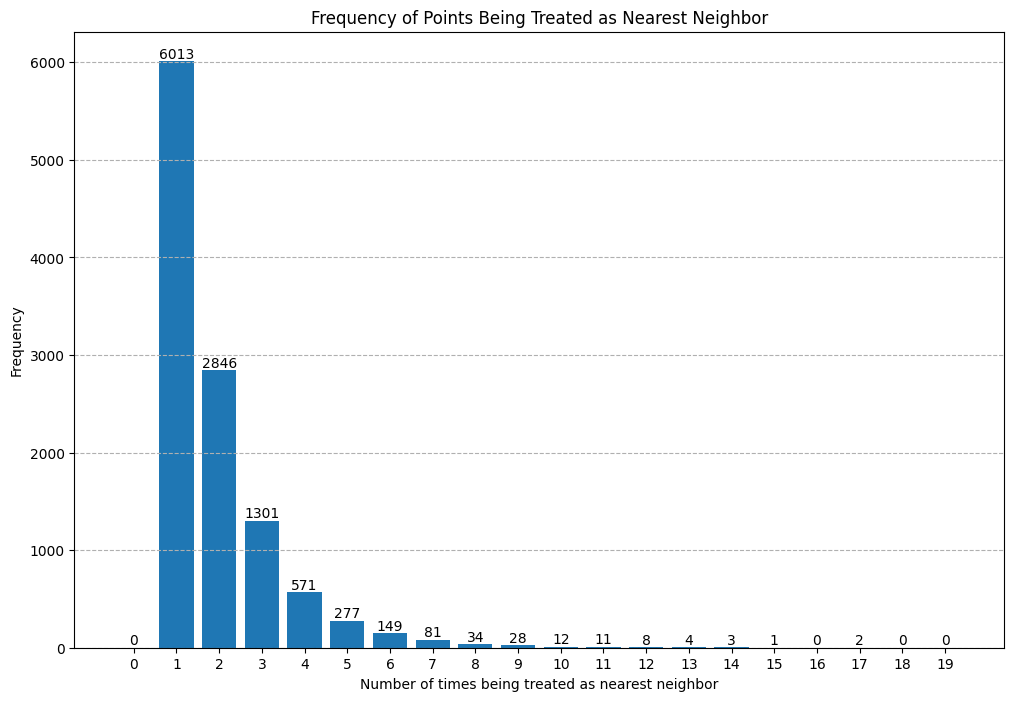

In [11]:
import numpy as np
import matplotlib.pyplot as plt

_, counts = np.unique(nearest_indices, return_counts=True)

# Calculate the frequency of frequencies within the range 0 to 19
freq_range = np.arange(20)
freq_of_freqs = [np.sum(counts == i) for i in freq_range]

# Plot the bar graph
plt.figure(figsize=(12, 8))
bars = plt.bar(freq_range, freq_of_freqs)
plt.xlabel('Number of times being treated as nearest neighbor')
plt.ylabel('Frequency')
plt.title('Frequency of Points Being Treated as Nearest Neighbor')
plt.xticks(freq_range)
plt.grid(axis='y', linestyle='--')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()